In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import pickle
import collections
import glob

import utils

import json

import matplotlib.pyplot as plt
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('colorblind')

In [2]:
tool_to_domain = {'biobloom': 'nt', 
                  'blastn': 'nt', 
                  'bwa': 'nt', 
                  'bowtie2': 'nt',
                  'groot': 'nt',
                  'hmmsearch_nt': 'nt',
                  'blastp': 'aa', 
                  'blastx': 'nt_to_aa',
                  'paladin': 'nt_to_aa', 
                  'diamond_blastx': 'nt_to_aa', 
                  'diamond_blastp': 'aa',
                  'hmmsearch_aa': 'aa'}

tool_to_paradigm = {'biobloom': 'k-mer', 
                  'blastn': 'BLAST', 
                  'bwa': 'BWT', 
                  'bowtie2': 'BWT',
                  'groot': 'k-mer',
                  'hmmsearch_nt': 'HMM',
                  'blastp': 'BLAST', 
                  'blastx': 'BLAST',
                  'paladin': 'BWT', 
                  'diamond_blastx': 'BLAST', 
                  'diamond_blastp': 'BLAST',
                  'hmmsearch_aa': 'HMM'}



# Performance

In [3]:
card = utils.CARD('../data/CARD_canonical/card.json')

In [4]:
TOTAL_SEQUENCES = 30317435


def filter_summarise(fp, domain, paradigm, tool, param):
    
    data = {}
    data['domain'] = domain
    data['tool'] = tool
    data['param'] = param
    data['paradigm'] = paradigm
    
    if tool == 'biobloom':
        df = pd.read_csv(fp, names=['metric', 'value'])
        df = df.set_index('metric')
        df = df.drop(['tool', 'params'])
        df['value'] = df['value'].astype(float)
        # prec = tp / tp+fp
        data['precision'] = df.loc['true_positive', 'value'] / (df.loc['true_positive', 'value'] + df.loc['false_positive', 'value'])
        df.loc['false_negative', 'value'] = df.loc['total', 'value'] - df.loc['true_positive', 'value']
        data['recall'] = df.loc['true_positive', 'value'] / (df.loc['true_positive', 'value'] + df.loc['false_negative', 'value'])
    
    elif tool.startswith('hmmsearch'):
        df = pd.read_csv(fp)
        # separate aro results from family false positives
        
        true_pos = (df['correct_family'] + df['wrong_family']).sum()
        fp = df['false_positive'].sum()
        
        data['precision'] = true_pos / (true_pos + fp)
        data['recall'] = true_pos / (true_pos + df['missed'].sum())
        
    else:
        df = pd.read_csv(fp)
        true_pos = (df['correct_aro'] + df['wrong_aro_correct_family'] + df['wrong_aro_wrong_family']).sum()
        data['precision'] = true_pos / (true_pos + df['false_positive'].sum())
        data['recall'] = true_pos / (true_pos + df['missed'].sum())
        
    data['f1_score'] = 2 / (1/data['recall'] + 1/data['precision'])
    return pd.Series(data)

In [6]:
filter_results = []

for tool_run in glob.glob('tool_runs/*.csv'):
    tool = tool_run.split('/')[1]
    if tool.startswith('diamond') or tool.startswith('hmmsearch'):
        params = '_'.join(tool.split('_')[2:]).replace('.csv', '')
        tool = '_'.join(tool.split('_')[:2])    
    else:
        params = '_'.join(tool.split('_')[1:]).replace('.csv', '')
        tool = tool.split('_')[0]
    
    domain = tool_to_domain[tool]
    paradigm = tool_to_paradigm[tool]
    
    filter_results.append(filter_summarise(tool_run, domain, paradigm, tool, params))
    


filter_results = pd.DataFrame(filter_results)
filter_results = filter_results.replace({'aa': 'Protein Query/DB',
                    'nt': 'DNA Query/DB',
                    'nt_to_aa': 'DNA Query, Protein DB'})

filter_results = filter_results.rename(columns={'tool': 'Tool',
                                                'paradigm': 'Paradigm',
                                                'domain': 'Domain',
                                                'recall': 'Recall',
                                                'precision': 'Precision'})



name_tidy = {'blastn': 'BLASTN', 'bwa': 'BWA-MEM', 'bowtie2': "Bowtie2", 'blastx': "BLASTX", 
             'diamond_blastx': "DIAMOND-BLASTX", 'paladin': "PALADIN", 'blastp': "BLASTP", 
             'diamond_blastp': "DIAMOND-BLASTP", 'hmmsearch_nt': 'HMMsearch-NT', 'hmmsearch_aa': 'HMMsearch-AA'}
filter_results['Tool'] = filter_results['Tool'].replace(name_tidy)


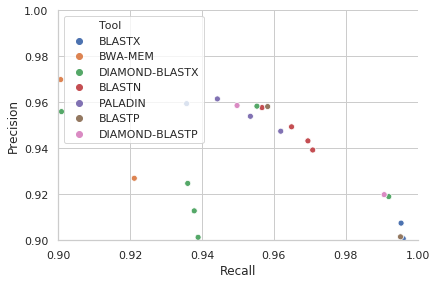

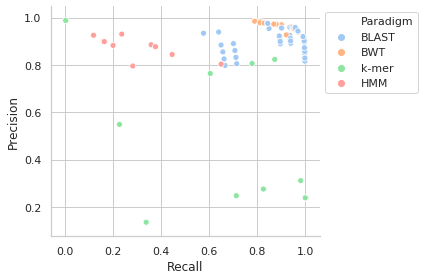

In [7]:
# sns.scatterplot(data = filter_results, y='Precision', x='Recall', hue='Tool')
# plt.title('AMR Precision-Recall Curve')
# plt.legend(bbox_to_anchor=(1,1))
# sns.despine()
# plt.tight_layout()
# plt.show()

high_filter_results = filter_results[(filter_results['Precision'] >= 0.9) & (filter_results['Recall'] >= 0.9)]
sns.scatterplot(data = high_filter_results, y='Precision', x='Recall', hue='Tool', palette = 'deep')
#plt.title('AMR Filtering Precision-Recall Curve')
plt.tight_layout()
plt.ylim(0.9, 1)
plt.xlim(0.9, 1)
#plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.savefig('figures/prec_recall_top.svg')

plt.show()


sns.scatterplot(data = filter_results, y='Precision', x='Recall', hue='Paradigm', palette = 'pastel')

plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.tight_layout()
plt.savefig('figures/prec_recall_all.svg')
plt.show()

# sns.scatterplot(data = filter_results, y='Precision', x='Recall', hue='Domain', palette = 'muted')
# plt.legend(bbox_to_anchor=(1,1))
# sns.despine()
# plt.tight_layout()
# plt.savefig('figures/F2C_domain.pdf')
# plt.savefig('figures/F2C_domain.png', dpi=300)

In [31]:
filter_results.query('Recall > 0.9').query('Precision > 0.9').sort_values('Recall')

,Domain,Tool,param,Paradigm,Precision,Recall,f1_score
20,DNA Query/DB,bwa,default_default,BWT,0.969913,0.900724,0.934039
22,"DNA Query, Protein DB",diamond_blastx,default_min100,BLAST,0.955975,0.900941,0.927643
51,DNA Query/DB,bwa,low_default,BWT,0.926984,0.921201,0.924083
43,"DNA Query, Protein DB",blastx,default_min100,BLAST,0.959440,0.935757,0.947450
36,"DNA Query, Protein DB",diamond_blastx,default_1e-10,BLAST,0.924761,0.936063,0.930378
56,"DNA Query, Protein DB",diamond_blastx,default_min50,BLAST,0.912810,0.937874,0.925172
92,"DNA Query, Protein DB",diamond_blastx,default_1e-5,BLAST,0.901302,0.938949,0.919741
50,"DNA Query, Protein DB",paladin,min25_default,BWT,0.961499,0.944311,0.952828
72,Protein Query/DB,diamond_blastp,more_sensitive_min100,BLAST,0.958643,0.949782,0.954192
91,"DNA Query, Protein DB",paladin,default_default,BWT,0.953942,0.953488,0.953715


In [30]:
filter_results.query('Recall > 0.9').query('Precision > 0.9').sort_values('Precision')

,Domain,Tool,param,Paradigm,Precision,Recall,f1_score
2,"DNA Query, Protein DB",blastx,default_min50,BLAST,0.900711,0.996004,0.945963
92,"DNA Query, Protein DB",diamond_blastx,default_1e-5,BLAST,0.901302,0.938949,0.919741
61,Protein Query/DB,blastp,default_1e-10,BLAST,0.901515,0.995243,0.946063
37,"DNA Query, Protein DB",blastx,default_1e-10,BLAST,0.907473,0.995408,0.949409
56,"DNA Query, Protein DB",diamond_blastx,default_min50,BLAST,0.912810,0.937874,0.925172
35,"DNA Query, Protein DB",diamond_blastx,more_sensitive_1e-10,BLAST,0.919013,0.991978,0.954103
85,Protein Query/DB,diamond_blastp,more_sensitive_1e-10,BLAST,0.919864,0.990704,0.953971
36,"DNA Query, Protein DB",diamond_blastx,default_1e-10,BLAST,0.924761,0.936063,0.930378
51,DNA Query/DB,bwa,low_default,BWT,0.926984,0.921201,0.924083
23,DNA Query/DB,blastn,default_1e-5,BLAST,0.939278,0.970822,0.954790


In [38]:
filter_results.query('Paradigm == "HMM"').sort_values('Recall')

,Domain,Tool,param,Paradigm,Precision,Recall,f1_score
83,DNA Query/DB,hmmsearch_nt,default_min100,HMM,0.925483,0.119723,0.212019
28,DNA Query/DB,hmmsearch_nt,default_1e-10,HMM,0.899215,0.160796,0.272809
77,DNA Query/DB,hmmsearch_nt,default_min50,HMM,0.898518,0.164458,0.278028
16,DNA Query/DB,hmmsearch_nt,default_1e-5,HMM,0.882447,0.200923,0.327320
18,Protein Query/DB,hmmsearch_aa,default_min100,HMM,0.930380,0.236998,0.377766
49,DNA Query/DB,hmmsearch_nt,default_default,HMM,0.795427,0.282841,0.417298
25,Protein Query/DB,hmmsearch_aa,default_1e-10,HMM,0.885234,0.359417,0.511257
42,Protein Query/DB,hmmsearch_aa,default_min50,HMM,0.877053,0.377340,0.527661
40,Protein Query/DB,hmmsearch_aa,default_1e-5,HMM,0.844055,0.446520,0.584061
80,Protein Query/DB,hmmsearch_aa,default_default,HMM,0.803416,0.650075,0.718657


In [24]:
filter_results.groupby('Tool')['Precision'].max().sort_values()

Tool
biobloom          0.823406
hmmsearch_nt      0.925483
hmmsearch_aa      0.930380
blastp            0.958183
diamond_blastx    0.958344
diamond_blastp    0.958643
blastx            0.959440
paladin           0.961499
bwa               0.973898
blastn            0.976654
bowtie2           0.984876
groot             0.988085
Name: Precision, dtype: float64

In [22]:
filter_results.groupby('Tool')['Recall'].max().sort_values()

Tool
groot             0.005641
hmmsearch_nt      0.282841
hmmsearch_aa      0.650075
bowtie2           0.879040
bwa               0.921201
paladin           0.961930
diamond_blastp    0.997315
diamond_blastx    0.997370
blastx            0.998323
blastp            0.998428
blastn            0.999445
biobloom          1.000000
Name: Recall, dtype: float64

In [7]:
filter_results.query('Tool=="groot"').sort_values('Recall')

,Domain,Tool,param,Paradigm,Precision,Recall,f1_score
70,DNA Query/DB,groot,card_k9_s128_j090_default,k-mer,0.987904,0.003896,0.007762
29,DNA Query/DB,groot,card_k7_s128_j090_default,k-mer,0.987919,0.003935,0.007840
15,DNA Query/DB,groot,card_k9_s256_j090_default,k-mer,0.987970,0.003975,0.007919
99,DNA Query/DB,groot,card_k7_s256_j090_default,k-mer,0.987926,0.004018,0.008003
82,DNA Query/DB,groot,card_k5_s128_j090_default,k-mer,0.987896,0.004031,0.008029
5,DNA Query/DB,groot,card_k5_s256_j090_default,k-mer,0.987912,0.004128,0.008222
58,DNA Query/DB,groot,card_k9_s64_j0990_default,k-mer,0.987582,0.004318,0.008598
17,DNA Query/DB,groot,card_k7_s64_j0990_default,k-mer,0.988085,0.004394,0.008749
68,DNA Query/DB,groot,card_k5_s64_j099_default,k-mer,0.987978,0.004427,0.008814
88,DNA Query/DB,groot,card_k9_s64_j0900_default,k-mer,0.987947,0.005523,0.010984


In [22]:
filter_results.sort_values('Recall').query('Tool == "hmmsearch_nt"')

,Domain,Tool,param,Paradigm,Precision,Recall,f1_score
83,DNA Query/DB,hmmsearch_nt,default_min100,HMM,0.925483,0.119723,0.212019
28,DNA Query/DB,hmmsearch_nt,default_1e-10,HMM,0.899215,0.160796,0.272809
77,DNA Query/DB,hmmsearch_nt,default_min50,HMM,0.898518,0.164458,0.278028
16,DNA Query/DB,hmmsearch_nt,default_1e-5,HMM,0.882447,0.200923,0.327320
49,DNA Query/DB,hmmsearch_nt,default_default,HMM,0.795413,0.282841,0.417296


## filter_results